# [SF-DST] Booking reviews

<div align='center'><img src="https://elteha.ru/images/some_photo/hotel_book.jpg" width="1200px"></div>

### Описание:
Представьте, что вы работаете датасаентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить. Вам поставлена задача создать такую модель.

### Условия соревнования:
Данное соревнование является бессрочным и доступно для всех потоков.
Срок выполнения соревнования устанавливается индивидуально в каждом потоке.
Тестовая выборка представлена в LeaderBoard целиком.
Делаем реальный ML продукт, который потом сможет нормально работать на новых данных.

# Подготовка рабочего пространства

In [ ]:
import pandas as pd
import numpy as np

DATA_DIR = '/content/'
df_train = pd.read_csv(DATA_DIR+'hotels_train.csv')               # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv')                 # датасет для предсказания
#sample_submission = pd.read_csv(DATA_DIR+'/submission.csv')      # самбмишн

In [ ]:
df_train['sample'] = 1           # помечаем где у нас трейн
df_test['sample'] = 0            # помечаем где у нас тест
df_test['reviewer_score'] = 0    # в тесте у нас нет значения reviewer_score, мы его должны предсказать, поэтому пока просто заполняем нулями

reviews_df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем train

In [ ]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [ ]:
# объединяем положительные и отрицательные отзывы
reviews_df["review"] = reviews_df["negative_review"] + reviews_df["positive_review"]

# создаём метку для плохого отзыва (1 - True, 0 - False)
reviews_df["is_bad_review"] = reviews_df["reviewer_score"].apply(lambda x: 1 if x < 5 else 0)

# выбираем только релевантные столбцы
reviews_df = reviews_df[["review", "is_bad_review", "reviewer_score", "sample"]]
reviews_df.head()

,review,is_bad_review,reviewer_score,sample
0,Would have appreciated a shop in the hotel th...,1,0.0,0
1,No tissue paper box was present at the roomNo...,1,0.0,0
2,Pillows Nice welcoming and service,1,0.0,0
3,No Negative Everything including the nice upgr...,1,0.0,0
4,No Negative Lovely hotel v welcoming staff,1,0.0,0


# Sample данные

In [ ]:
reviews_df = reviews_df.sample(frac = 0.1, replace = False, random_state=42)

# Очистка данных

In [ ]:
# удалим 'No Negative' или 'No Positive' из текста
reviews_df["review"] = reviews_df["review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

In [ ]:
# https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/
# использование wordnet для анализа частей речи

import nltk
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer


def clean_text(text):
    # приводим к нижнему регистру
    text = text.lower()
    # разделение текста на слова и удаление знаков препинания
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # удаляем цифры из текста
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # удаляем стоп-слова
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # удаляем пустые токены
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # лемматизация текста
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # удаляем слова из одной буквы
    text = [t for t in text if len(t) > 1]
    # объединяем текст
    text = " ".join(text)
    return(text)

# очистка текстовых данных
reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Создание новых признаков

In [ ]:
# https://habr.com/ru/company/Voximplant/blog/446738/
# анализ тональности (настроения) текста отзыва

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# создадим признак кол-во символов в отзыве
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))

# создадим признак кол-во слов в отзыве
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))

In [ ]:
# https://habr.com/ru/post/585838/
# векторизация слов с помощью doc2vec и создание нового признака

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# обучение модели Doc2Vec с помощью текстовых данных
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# преобразуем каждый документ в вектор данных
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

In [ ]:
# создание признака tf-idfs (оценка важности слова в тексте)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
reviews_df.head()

,review,is_bad_review,reviewer_score,sample,review_clean,neg,neu,pos,compound,nb_chars,...,word_yet,word_yoghurt,word_yogurt,word_young,word_yummy,word_zero,word_ziggo,word_zone,word_zoo,word_zuid
488440,The tea cups were dirty on arrival We also ha...,0,7.1,1,tea cup dirty arrival also connect door anothe...,0.018,0.663,0.318,0.9868,418,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274649,Not a big enough choice,0,6.7,1,big enough choice,0.000,1.000,0.000,0.0000,24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
374688,Room was a bit dirty the a c did not work ver...,0,5.4,1,room bit dirty work well staff courteous frien...,0.233,0.507,0.260,0.4199,112,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404352,Great location for morning walks in the park ...,0,10.0,1,great location morning walk park also shop aro...,0.000,0.695,0.305,0.9081,171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
451596,The balcony in the room was very depressing w...,0,7.5,1,balcony room depress view table chair outside ...,0.063,0.783,0.153,0.9016,631,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
reviews_df.shape

(51574, 3861)

# Исследовательский анализ данных

In [ ]:
# распределение данных в столбце is_bad_review
reviews_df["is_bad_review"].value_counts(normalize = True)

0    0.71982
1    0.28018
Name: is_bad_review, dtype: float64

Our dataset is highly imbalanced because less than 5% of our reviews are considered as negative ones. This information will be very useful for the modelling part.

Now let's print some wordclouds to have a glimpse at what kind of words apear in our reviews:

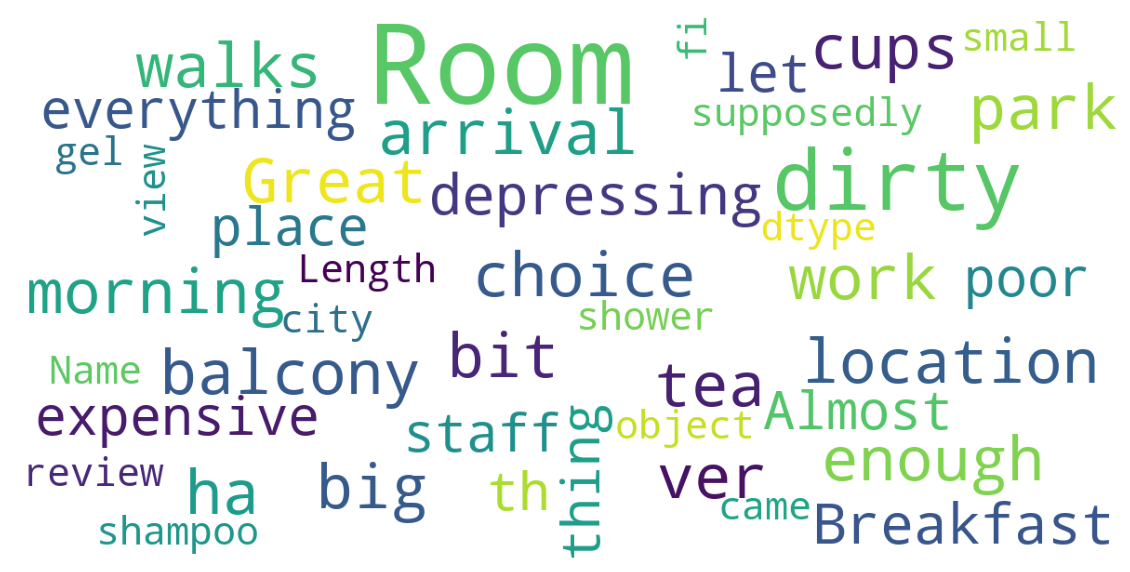

In [ ]:
# использование wordcloud функции

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40,
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(reviews_df["review"])

In [ ]:
# Топ позитивных отзывов (содержит > 5 слов)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

,review,pos
509325,Clean comfortable efficient,1.000
245292,Nice clean comfortable,1.000
141924,Clean helpful efficient,1.000
333927,Great clean comfortable Great concierge,0.934
411351,Excellent service super comfortable,0.916
368656,Clean friendly lovely rooms,0.907
488108,Great staff helpful smiley,0.906
868,Friendly welcome Comfortable room,0.905
53608,Smile More friendly I hope,0.902
221411,Comfortable clean and friendly,0.902


In [ ]:
# Топ негативных отзывов (содержит > 5 слов)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)

,review,neg
74453,All No no no,0.868
276567,Uncomfortable bed noisy,0.811
32377,A disaster Nothing,0.804
283853,Noisy no view,0.796
38524,Very bad service No,0.758
309172,Nothing Excellent,0.750
461033,Nothing Perfect,0.750
419280,Nothing Great friendly staff,0.748
66684,Nothing Loved it thanks,0.735
263821,Nothing Welcoming happy staff,0.730


In [ ]:
reviews_df.head()

,review,is_bad_review,reviewer_score,sample,review_clean,neg,neu,pos,compound,nb_chars,...,word_yet,word_yoghurt,word_yogurt,word_young,word_yummy,word_zero,word_ziggo,word_zone,word_zoo,word_zuid
488440,The tea cups were dirty on arrival We also ha...,0,7.1,1,tea cup dirty arrival also connect door anothe...,0.018,0.663,0.318,0.9868,418,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274649,Not a big enough choice,0,6.7,1,big enough choice,0.000,1.000,0.000,0.0000,24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
374688,Room was a bit dirty the a c did not work ver...,0,5.4,1,room bit dirty work well staff courteous frien...,0.233,0.507,0.260,0.4199,112,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404352,Great location for morning walks in the park ...,0,10.0,1,great location morning walk park also shop aro...,0.000,0.695,0.305,0.9081,171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
451596,The balcony in the room was very depressing w...,0,7.5,1,balcony room depress view table chair outside ...,0.063,0.783,0.153,0.9016,631,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Предсказание reviewer_score

In [ ]:
# Импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [ ]:
# Теперь выделим тестовую часть
train_data = reviews_df.query('sample == 1').drop(['sample'], axis=1)
test_data = reviews_df.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score','review','review_clean'], axis=1)

# X = X[['is_bad_review','pos','neg','compound','doc2vec_vector_0','doc2vec_vector_1','doc2vec_vector_2','doc2vec_vector_3','doc2vec_vector_4','word_room',
#       'word_small','nb_chars','word_nothing','word_good','neu','nb_words','word_location','word_everthing','word_staff','word_breakfast']]
# X.head()

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((12821, 3860), (38753, 3860), (38753, 3857), (31002, 3857), (7751, 3857))

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 19.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.4s finished


In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.8143065200572482


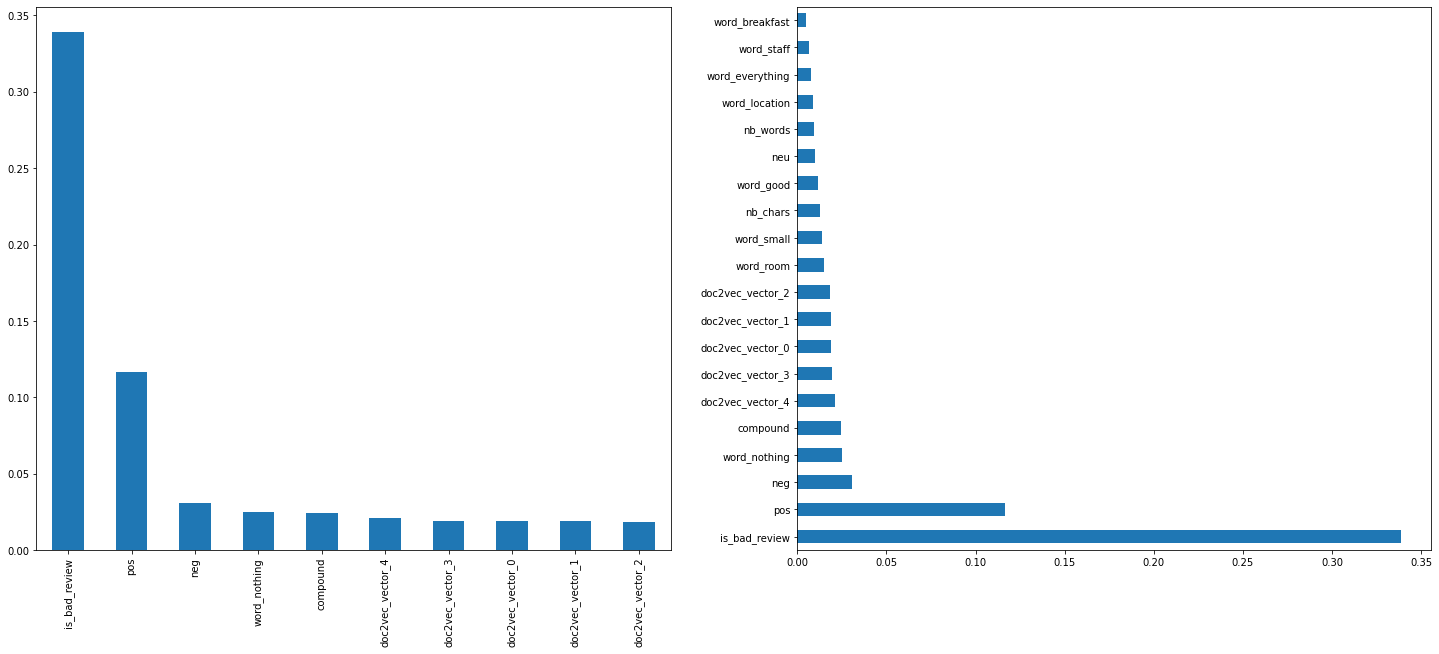

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (25,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

plt.subplot(1, 2, 2)
feat_importances.nlargest(20).plot(kind='barh')
plt.subplot(1, 2, 1)
feat_importances.nlargest(10).plot(kind='bar')

In [ ]:
# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred.round(1)))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred.round(1)))

MAE: 0.8143852406141142
MAPE: 10.838607806602187
